<a href="https://colab.research.google.com/github/G-Gaddu/Quant-Material/blob/main/Volatility_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 5.3 MB/s eta 0:00:00


In [86]:
# Import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import yfinance as yf

from arch import arch_model
from pmdarima.model_selection import train_test_split
from scipy.stats import chi2, jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
import datetime
from sklearn.metrics import mean_squared_error, r2_score


In [44]:
# Get the data
start = datetime.datetime(2014,1,1)
end = datetime.datetime(2023, 1, 1)
ticker = '^FTSE'
data = yf.download(ticker, start=start, end=end)
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,6749.100098,6759.399902,6707.500000,6717.899902,6717.899902,459529100
2014-01-03,6717.899902,6747.299805,6699.299805,6730.700195,6730.700195,374841500
2014-01-06,6730.700195,6752.000000,6714.600098,6730.700195,6730.700195,524387000
2014-01-07,6730.700195,6768.899902,6718.100098,6755.500000,6755.500000,672375600
2014-01-08,6755.500000,6755.500000,6713.399902,6721.799805,6721.799805,720025300


In [45]:
data_close = data['Close']
data_close.head()

,Close
Date,
2014-01-02,6717.899902
2014-01-03,6730.700195
2014-01-06,6730.700195
2014-01-07,6755.500000
2014-01-08,6721.799805


In [46]:
# Determine the log returns
data_close['Log_Ret'] = np.pad(np.diff(np.log(data_close))*100, (1,0), 'constant', constant_values=np.nan)

<ipython-input-46-1c1c6a0c6ae5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_close['Log_Ret'] = np.pad(np.diff(np.log(data_close))*100, (1,0), 'constant', constant_values=np.nan)


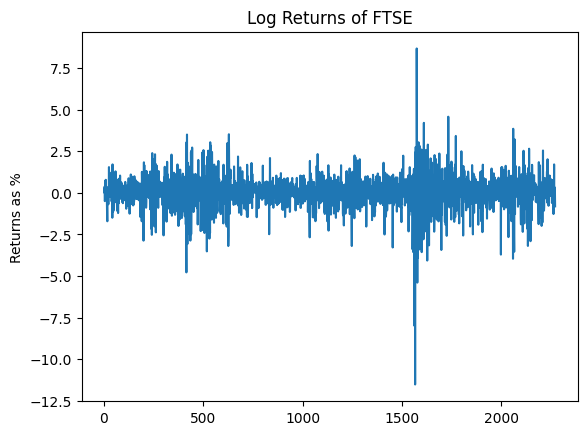

In [48]:
# Plot them
plt.figure()
plt.plot(data_close['Log_Ret'])
plt.title('Log Returns of FTSE')
plt.ylabel('Returns as %')
plt.show()

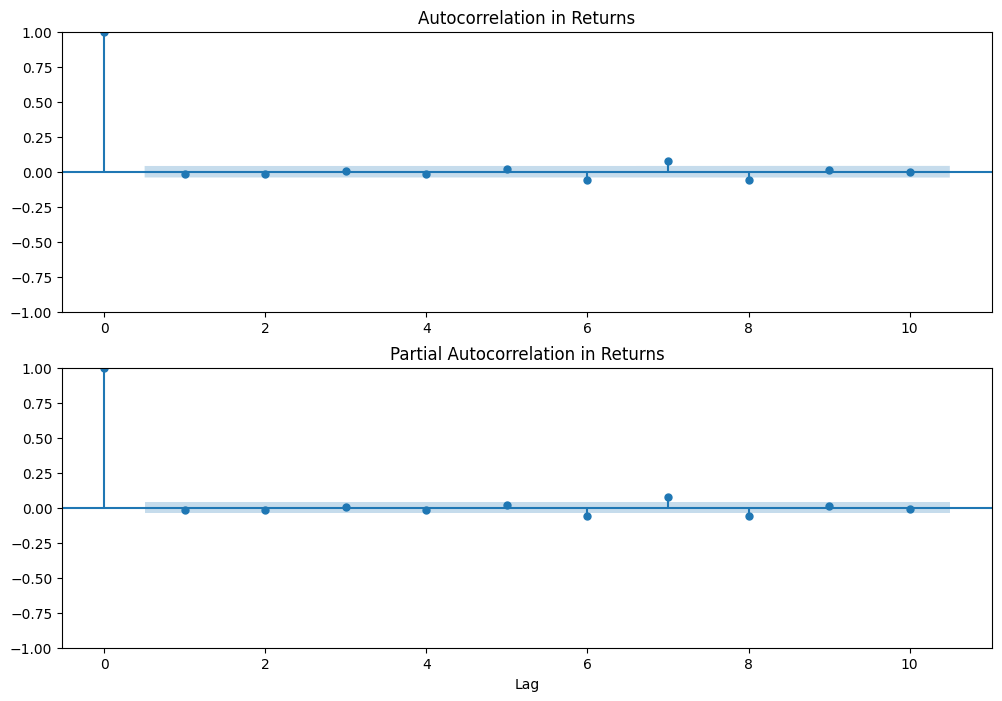

In [49]:
# Plot the ACFs and PACFs
plot_data = pd.DataFrame(data_close['Log_Ret'])
diff_ts = plot_data.iloc[1:]
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(diff_ts, ax=ax1, lags=10)
plot_pacf(diff_ts, ax=ax2, lags=10)
ax2.set_xlabel('Lag')
ax1.set_title('Autocorrelation in Returns')
ax2.set_title('Partial Autocorrelation in Returns')
plt.show()


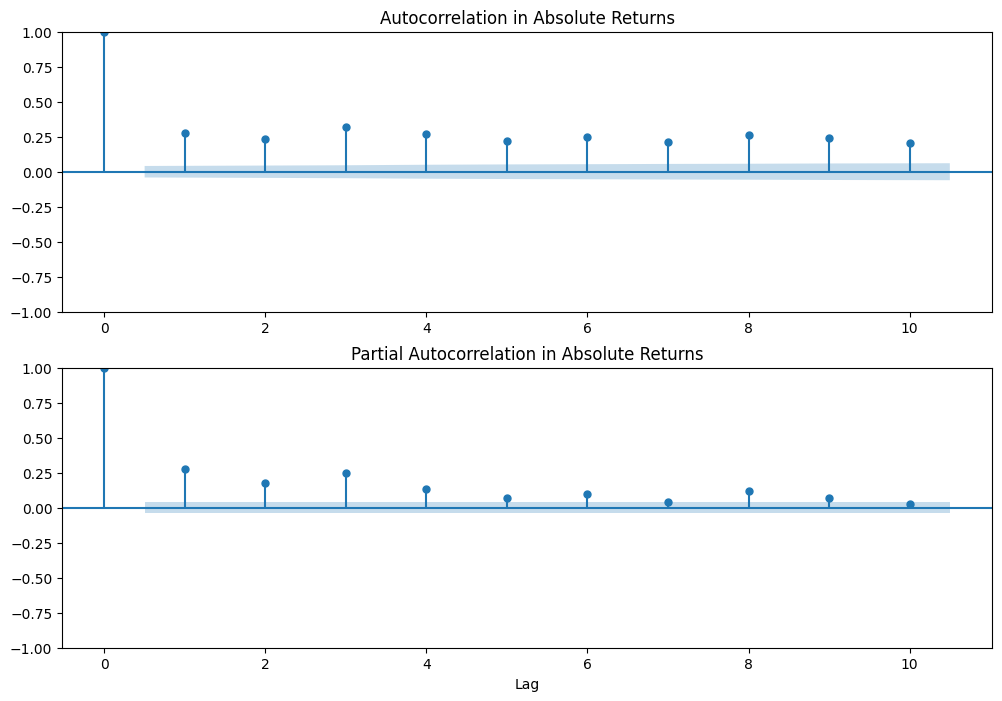

In [53]:
# To confirm this  we repeat the process but with absolute returns (we can use squared returns but absolute minimises the effects of outliers)
abs_data = diff_ts.abs()
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(abs_data, ax=ax1, lags=10)
plot_pacf(abs_data, ax=ax2, lags=10)
ax2.set_xlabel('Lag')
ax1.set_title('Autocorrelation in Absolute Returns')
ax2.set_title('Partial Autocorrelation in Absolute Returns')
plt.show()

In [55]:
# Create a McLeod Li test to check for white noice behavior in the residuals of the series
def mcleod_li_test(a,k):
  n = len(a)
  a_sq = a ** 2
  a_sq_sum = np.sum(a_sq)
  a_lag_sum = np.sum(a_sq[:-k])
  test_stat = n*(n+2)*a_lag_sum/(a_sq_sum**2)
  df = k
  p_value = 1 -chi2.cdf(test_stat, df)
  return test_stat, p_value


In [57]:
# Get the stats
mcli_stat, p_value = mcleod_li_test(abs_data, 50)
print("McLeod Li Test:")
print("Test Statistic:", mcli_stat)
print("P-value:", p_value)

McLeod Li Test:
Test Statistic: 0    2139.614105
dtype: float64
P-value: [0.]


In [60]:
# Fit the GARCH model onto the data using a 80-20 train test split and a defulat GARCH(1,1)
y_train, y_test = train_test_split(abs_data, train_size = 0.8)
GARCH_model = arch_model(y_train, mean = "Zero", vol='Garch',p=1, rescale=False)
results_garch = GARCH_model.fit()
print(results_garch.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1016529342.5501194
Iteration:      2,   Func. Count:     12,   Neg. LLF: 2994.595695969946
Iteration:      3,   Func. Count:     17,   Neg. LLF: 2542.5141866522035
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3048.9735751523044
Iteration:      5,   Func. Count:     28,   Neg. LLF: 2311.157881975158
Iteration:      6,   Func. Count:     32,   Neg. LLF: 2311.0845644875276
Iteration:      7,   Func. Count:     36,   Neg. LLF: 2311.0757241692977
Iteration:      8,   Func. Count:     40,   Neg. LLF: 2311.073496359345
Iteration:      9,   Func. Count:     44,   Neg. LLF: 2311.0734298453326
Iteration:     10,   Func. Count:     48,   Neg. LLF: 2311.0734276926123
Iteration:     11,   Func. Count:     51,   Neg. LLF: 2311.0734276925637
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2311.0734276926123
            Iterations: 11
            Function evaluations: 51
            Gradient evalua

In [70]:
# Now we can forecast the future volatilities using the model and an N step ahead forecast approach
y_pred = results_garch.forecast(horizon=y_test.shape[0], reindex=True)

In [71]:
print(y_pred)

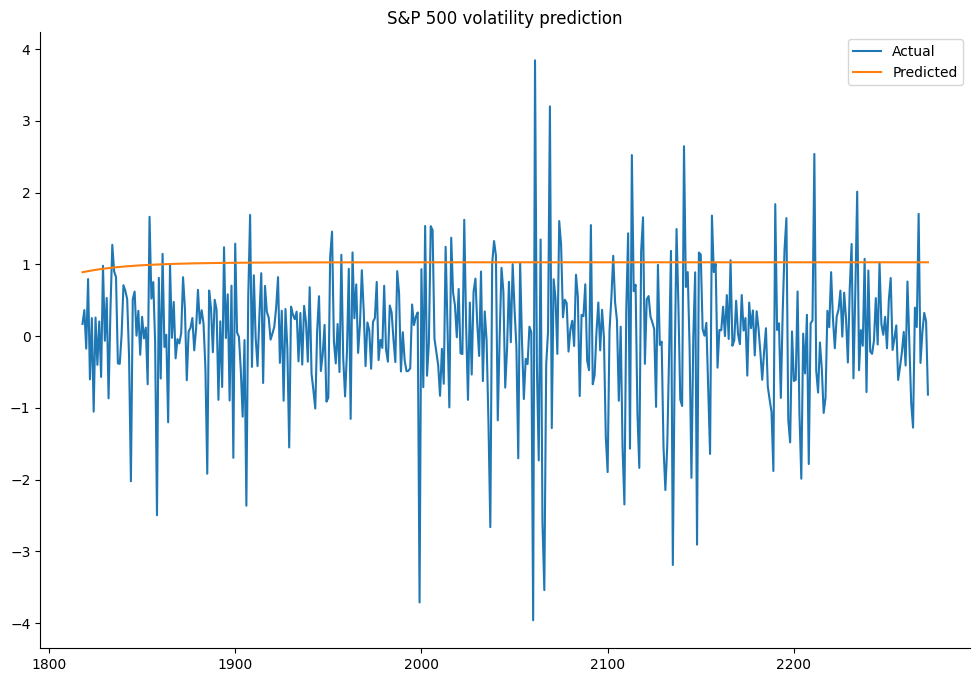

In [77]:
# Plot the predictions against the values
fig,ax = plt.subplots(figsize=(12,8))
ax.spines[['top','right']].set_visible(False)
plt.plot(diff_ts[-y_test.shape[0]:])
plt.plot(y_test.index, np.sqrt(y_pred.variance.values[-1,:]))
plt.title('S&P 500 volatility prediction')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [87]:
mse = mean_squared_error(diff_ts[-y_test.shape[0]:], np.sqrt(y_pred.variance.values[-1,:]))
print("Mean Squared Error:", mse)

Mean Squared Error: 1.839633853537505


In [88]:
r2 = r2_score(diff_ts[-y_test.shape[0]:], np.sqrt(y_pred.variance.values[-1,:]))
print("R-squared:", r2)

R-squared: -1.1862078411740695


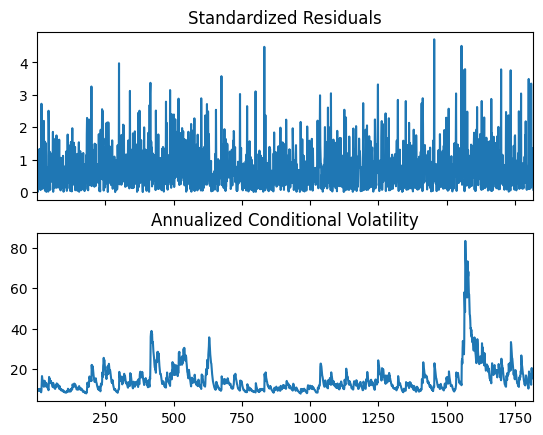

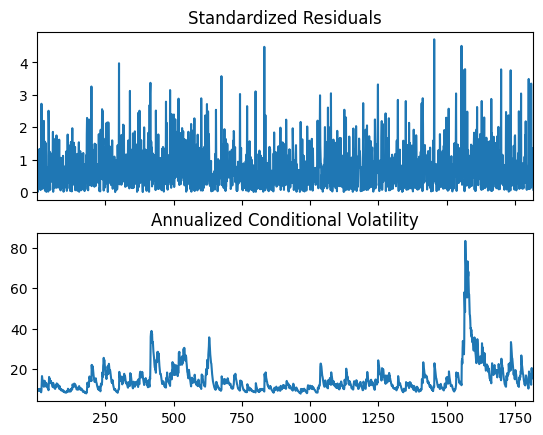

In [79]:
# Conditional volatility by model fitting
results_garch.plot(annualize="D")

In [80]:
# We can also make only one step ahead predictions i.e. predict for the next day only
rolling_ypred = []
for i in range(y_test.shape[0]):
  train = abs_data[:-(y_test.shape[0]-i)]
  model = arch_model(train, p=1,q=1, rescale=False)
  model_fit = model.fit(disp='off')
  preds = model_fit.forecast(horizon=1, reindex=True)
  rolling_ypred.append(np.sqrt(preds.variance.values[-1,:][0]))
rolling_ypred = pd.Series(rolling_ypred, index=y_test.index)

Text(0.5, 1.0, 'FTSE Rolling Volatility Prediction')

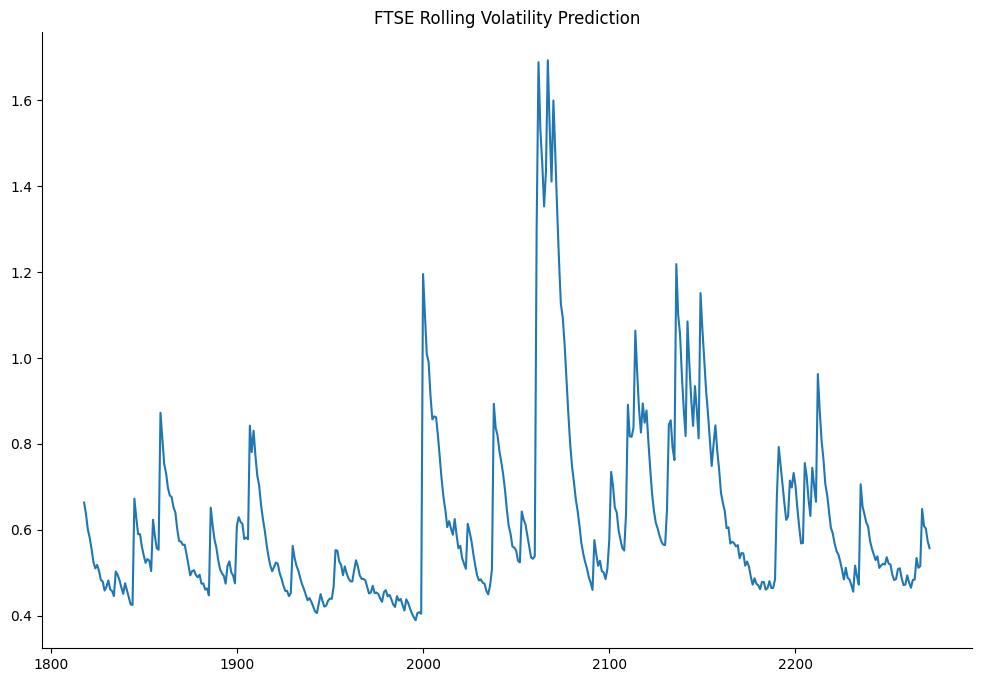

In [83]:
# Plot the predictions
fig,ax = plt.subplots(figsize=(12,8))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_ypred)
plt.title('FTSE Rolling Volatility Prediction')

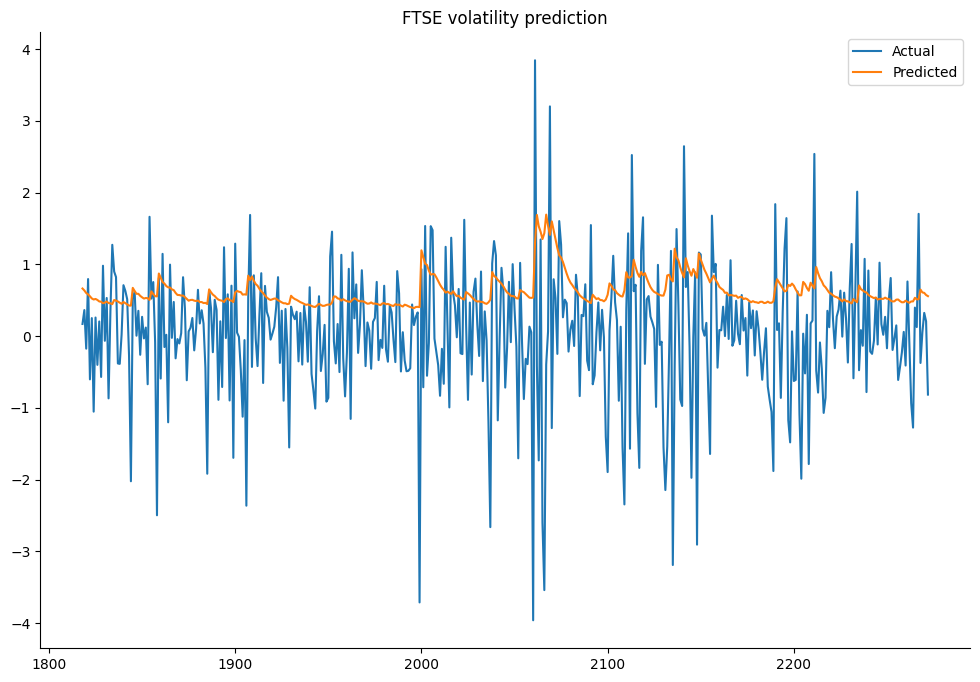

In [84]:
# Plot the actual vs predictions
fig, ax = plt.subplots(figsize=(12,8))
ax.spines[['top','right']].set_visible(False)
ax.plot(diff_ts[-y_test.shape[0]:])
ax.plot(y_test.index, rolling_ypred)
plt.title('FTSE volatility prediction')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [89]:
mse2 = mean_squared_error(diff_ts[-y_test.shape[0]:], rolling_ypred)
print("Mean Squared Error:", mse2)

Mean Squared Error: 1.220236445351442


In [90]:
r22 = r2_score(diff_ts[-y_test.shape[0]:], rolling_ypred)
print("R-squared:", r22)

R-squared: -0.450120348559518


In [85]:
# Determine the Jarque Bera Test figure to test if the residuals follow a normal distribution
std_resid = results_garch.resid/results_garch.conditional_volatility
jb_stat, p_value = jarque_bera(std_resid)
print("Jarque Bera Test:")
print("Test Statistic:", jb_stat)
print("P-value:", p_value)

Jarque Bera Test:
Test Statistic: 2129.544441622703
P-value: 0.0
